# AE CIC-IDS-2017

La última fase de la evaluación conlleva la evaluación de los modelos en dominios similares. Para ello, se utilizó el CIC-IDS-2017, el conjunto de datos predecesor del utilizado en  este proyecto. A continuación se muestran las
métricas y el porcentaje de ataques detectados para la técnica de AE.

## Librerías necesarias

In [1]:
import gc
from os import getcwd
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
import gc
import tensorflow as tf
import seaborn as sns

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import MinMaxScaler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

pd.set_option("display.max_columns", 80)

## Carga del conjunto de datos

In [2]:
df = pd.read_csv('/home/jovyan/CIC-IDS-2017/CIC-IDS-2017.csv', sep=',', low_memory=False)

df

,Destination Port,xhr,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Max,Fwd PSH Flags,Fwd Packets/s,Bwd Packets/s,RST Flag Count,PSH Flag Count,ACK Flag Count,Init_Win_bytes_forward,Init_Win_bytes_backward,min_seg_size_forward,Idle Min,Protocol_6,Protocol_17,Label
0,0.001343,0.0,0.008864,0.000000,0.010580,0.000000,0.015430,4.483333e-06,1.494444e-06,4.416667e-06,0.0,0.003646,3.125000e-03,0.0,1.0,0.0,0.125015,0.031342,1.0,0.0,1.0,0.0,0
1,0.001343,0.0,0.012087,0.000000,0.011222,0.000000,0.126886,6.383333e-06,2.127778e-06,6.316667e-06,0.0,0.003333,2.222222e-03,0.0,1.0,0.0,0.125015,0.031342,1.0,0.0,1.0,0.0,0
2,0.001343,0.0,0.055923,0.000000,0.066753,0.000000,0.121972,7.725000e-06,2.575000e-06,7.300000e-06,0.0,0.001936,1.659751e-03,0.0,1.0,0.0,0.125015,0.031342,1.0,0.0,1.0,0.0,0
3,0.001343,0.0,0.009106,0.000000,0.010869,0.000000,0.015947,3.850000e-06,1.283333e-06,3.433333e-06,0.0,0.004566,3.913894e-03,0.0,1.0,0.0,0.125015,0.031342,1.0,0.0,1.0,0.0,0
4,0.001343,0.0,0.012329,0.000000,0.011446,0.000000,0.126886,5.625000e-06,1.875000e-06,5.225000e-06,0.0,0.003881,2.587322e-03,0.0,1.0,0.0,0.125015,0.031342,1.0,0.0,1.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2712394,0.000809,0.0,0.001128,0.012043,0.004713,0.026243,0.013102,2.500000e-08,2.500000e-08,2.500000e-08,0.0,0.000041,3.104144e-05,0.0,0.0,0.0,0.000000,0.000000,1.0,0.0,1.0,0.0,0
2712395,0.000809,0.0,0.001692,0.018065,0.007070,0.062500,0.031204,1.666667e-08,1.666667e-08,1.666667e-08,0.0,0.002058,3.086420e-03,0.0,0.0,0.0,0.000000,0.000000,1.0,0.0,1.0,0.0,0
2712396,0.885481,0.0,0.001249,0.000000,0.002609,0.002072,0.001034,0.000000e+00,0.000000e+00,0.000000e+00,1.0,0.008130,6.097561e-03,0.0,0.0,1.0,0.015366,0.000015,1.0,0.0,1.0,0.0,0
2712397,0.000809,0.0,0.001289,0.013763,0.005386,0.044199,0.022067,2.500000e-08,2.500000e-08,2.500000e-08,0.0,0.000002,9.536207e-07,0.0,0.0,0.0,0.000000,0.000000,1.0,0.0,1.0,0.0,0


Text(0.5, 1.0, 'Distribución del tráfico')

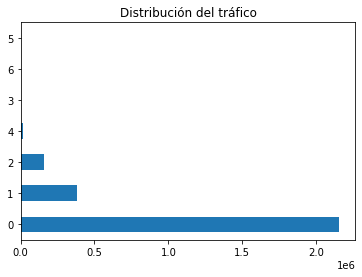

In [3]:
df[' Label'].value_counts().plot(kind='barh')
plt.title('Distribución del tráfico')

## Tratamiento del conjunto de datos

Se eliminan atributos que son irrelevantes a priori.

Text(0.5, 1.0, 'Correlación respecto a target')

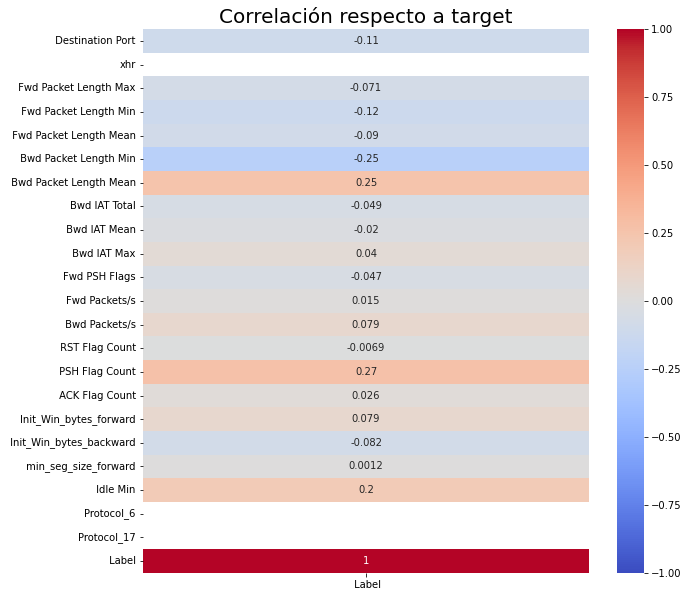

In [4]:
corr = df.corr()

plt.figure(figsize=(10,10))
#figure.tight_layout(pad=3.5, rect=[0, 0.03, 1, 0.95])
sns.heatmap(corr[[' Label']], cmap='coolwarm', annot=True, vmin=-1).set_title('Correlación respecto a target', fontsize=20)

In [5]:
df.drop(['xhr', 'Protocol_6', 'Protocol_17'], axis=1, inplace=True)

In [6]:
kot = df.corr()
drop_cols = []
i = -1
for corr in kot[' Label']:
    i+=1
    if abs(corr) < 0.05:
        drop_cols.append(df.columns[i])

In [7]:
print(drop_cols)
len(drop_cols)

['Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Max', 'Fwd PSH Flags', 'Fwd Packets/s', ' RST Flag Count', ' ACK Flag Count', ' min_seg_size_forward']


8

In [8]:
df.drop(drop_cols, axis=1, inplace=True)

Text(0.5, 1.0, 'Correlación respecto a target')

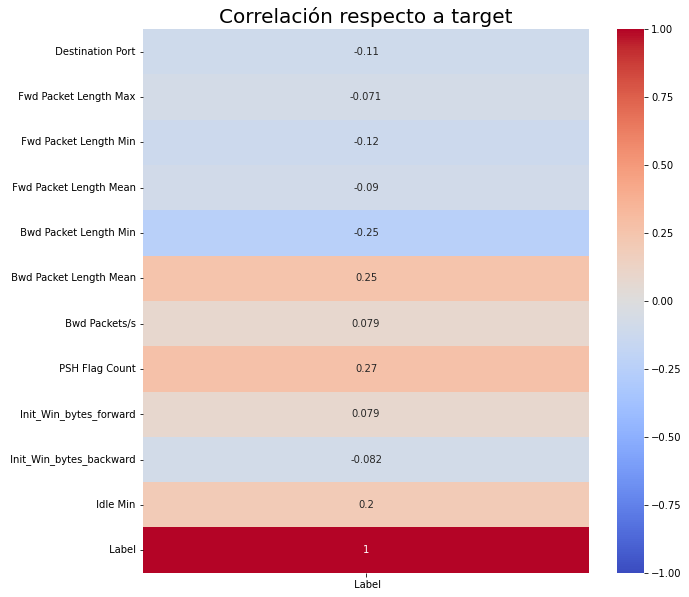

In [9]:
corr = df.corr()

plt.figure(figsize=(10,10))
#figure.tight_layout(pad=3.5, rect=[0, 0.03, 1, 0.95])
sns.heatmap(corr[[' Label']], cmap='coolwarm', annot=True, vmin=-1).set_title('Correlación respecto a target', fontsize=20)

In [10]:
#cols = [' Destination Port', ' Fwd Packet Length Min', ' Fwd Packet Length Mean', ' Bwd Packet Length Min', ' Bwd Packets/s', 'Init_Win_bytes_forward', ' Init_Win_bytes_backward', ' min_seg_size_forward', 'Protocol_6', 'Protocol_17', ' Label']
#df = df[cols]

## Partición de conjuntos normales y anómalos

Se entrenará el autoencoder utilizando sólo los flujos normales, que en este conjunto de datos están etiquetados como 0. Deben separarse los flujos normales de los anómalos.

In [11]:
y = df.pop(' Label')
X = df.values

In [12]:
# Partición del conjunto de datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

In [13]:
def count_values(array):
    y = np.bincount(array)
    ii = np.nonzero(y)[0]
    return np.vstack((ii,y[ii])).T

In [14]:
count_values(y_train)

array([[      0, 1509769],
       [      1,  265869],
       [      2,  110999],
       [      3,    1391],
       [      4,    9738],
       [      5,      27],
       [      6,     886]])

In [15]:
count_values(y_test)

array([[     0, 647015],
       [     1, 113868],
       [     2,  47805],
       [     3,    565],
       [     4,   4094],
       [     5,      9],
       [     6,    364]])

In [16]:
test_data = tf.cast(X_test, tf.float32)

In [17]:
test_labels = tf.cast(y_test, tf.int16)
train_labels = tf.cast(y_train, tf.int16)

In [18]:
normal_test_data = X_test[np.where(test_labels == 0)]
normal_train_data = X_train[np.where(train_labels == 0)]
anomalous_train_data = X_train[np.where(train_labels != 0)]

In [19]:
clfIF = IsolationForest(n_estimators=100, max_samples='auto', contamination=0.35, max_features=1.0, n_jobs=-1)
clfIF.fit(pd.DataFrame(normal_train_data))
pred_train = clfIF.predict(pd.DataFrame(normal_train_data))

In [20]:
normal = pd.DataFrame(normal_train_data)
normal['Label'] = y_train
normal['anomaly'] = pred_train
outliers = normal.loc[normal['anomaly']==-1]
outlier_index = list(outliers.index)
print(normal['anomaly'].value_counts())
normal.drop(['anomaly'], axis=1, inplace=True)

 1    981354
-1    528415
Name: anomaly, dtype: int64


In [21]:
normal = normal.iloc[normal.index.difference(outlier_index)]
normal.reset_index(drop=True, inplace = True)
normal.describe()

,0,1,2,3,4,5,6,7,8,9,10,Label
count,981354.000000,981354.000000,981354.000000,981354.000000,981354.000000,981354.000000,9.813540e+05,981354.000000,981354.000000,981354.000000,981354.000000,686808.000000
mean,0.118874,0.002372,0.010799,0.005434,0.020585,0.016023,1.905791e-03,0.099033,0.026789,0.001201,0.004607,0.341088
std,0.274684,0.004141,0.008842,0.003902,0.019851,0.021828,3.602596e-03,0.298706,0.083729,0.005334,0.021333,0.760994
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000809,0.000242,0.000000,0.001010,0.000000,0.000000,4.829325e-07,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000809,0.001491,0.013763,0.005891,0.019682,0.012413,1.637559e-05,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.006760,0.001894,0.018495,0.007575,0.035912,0.020343,4.048583e-03,0.000000,0.003922,0.000000,0.000000,0.000000
max,0.999435,0.042345,0.032688,0.047524,0.077348,0.179226,8.333333e-02,1.000000,0.652359,0.274979,0.375833,6.000000


In [22]:
y_train = normal.pop('Label')
X_train = normal.values

## Carga del modelo

In [23]:
class AnomalyDetector(Model):
    
    def __init__(self):
        super(AnomalyDetector, self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.Dense(5, activation="relu"),
            layers.Dense(3, activation="relu")
        ])
        self.decoder = tf.keras.Sequential([
            layers.Dense(5, activation="relu"),
            layers.Dense(X_train.shape[1], activation="sigmoid")
        ])
    
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
    def pred(self, data, threshold):
        reconstructions = self(data)
        loss = tf.keras.losses.mae(reconstructions, data)
        return tf.math.less(threshold, loss)

    def print_stats(self, predictions, labels):
        labels = np.where(labels > 0, 1, labels)
        labels = labels.astype(bool)
        print("Accuracy = {}".format(accuracy_score(labels, preds)))
        print("Precision = {}".format(precision_score(labels, preds)))
        print("Recall = {}".format(recall_score(labels, preds)))

In [24]:
autoencoder = AnomalyDetector()
autoencoder.compile(optimizer='adam', loss='mae')

In [25]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
history = autoencoder.fit(normal_train_data, normal_train_data, 
          epochs=20, 
          batch_size=512,
          callbacks=[stop_early],
          shuffle=True)

Epoch 1/20
2949/2949 [==============================] - 7s 2ms/step - loss: 0.0864
Epoch 2/20
2949/2949 [==============================] - 6s 2ms/step - loss: 0.0568
Epoch 3/20
2949/2949 [==============================] - 6s 2ms/step - loss: 0.0516
Epoch 4/20
2949/2949 [==============================] - 6s 2ms/step - loss: 0.0441
Epoch 5/20
2949/2949 [==============================] - 6s 2ms/step - loss: 0.0438
Epoch 6/20
2949/2949 [==============================] - 6s 2ms/step - loss: 0.0438
Epoch 7/20
2949/2949 [==============================] - 6s 2ms/step - loss: 0.0437
Epoch 8/20
2949/2949 [==============================] - 6s 2ms/step - loss: 0.0437
Epoch 9/20
2949/2949 [==============================] - 6s 2ms/step - loss: 0.0437
Epoch 10/20
2949/2949 [==============================] - 6s 2ms/step - loss: 0.0435
Epoch 11/20
2949/2949 [==============================] - 6s 2ms/step - loss: 0.0434
Epoch 12/20
2949/2949 [==============================] - 6s 2ms/step - loss: 0.0433
E

## Detección de anomalías

20220/20220 [==============================] - 22s 1ms/step


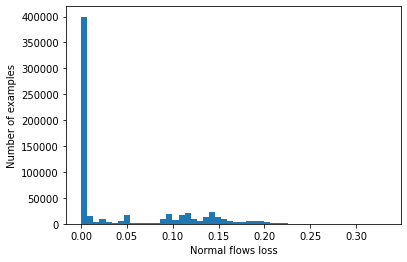

In [28]:
reconstructions = autoencoder.predict(normal_test_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_test_data)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Normal flows loss")
plt.ylabel("Number of examples")
plt.show()

In [29]:
th = 0.05
print("Normal detected: " + str((len(np.where(train_loss.numpy() < th)[0]) / len(train_loss.numpy())) * 100), "%.")

Normal detected: 69.89729758970039 %.


In [30]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: " + str(threshold))

Threshold: 0.10551599735890113


5210/5210 [==============================] - 6s 1ms/step


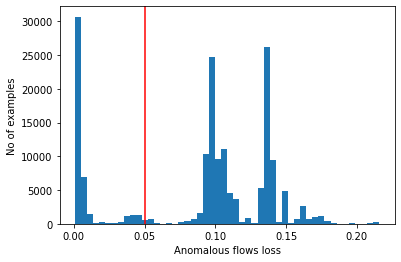

Anomalies detected: 73.81602231486758 %.


In [31]:
dos = X_test[np.where(test_labels != 0)]
reconstructions = autoencoder.predict(dos)
test_loss = tf.keras.losses.mae(reconstructions, dos)

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Anomalous flows loss")
plt.ylabel("No of examples")
plt.axvline(x = th, color = 'r', label = 'axvline - full height')
plt.show()

print("Anomalies detected: " + str((len(np.where(test_loss.numpy() > th)[0]) / len(test_loss.numpy())) * 100), "%.")

3559/3559 [==============================] - 4s 1ms/step


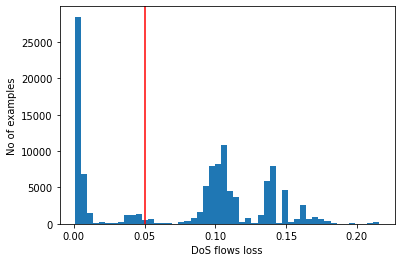

Anomalies detected: 63.675483893631224 %.


In [32]:
dos = X_test[np.where(test_labels == 1)]
reconstructions = autoencoder.predict(dos)
test_loss = tf.keras.losses.mae(reconstructions, dos)

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("DoS flows loss")
plt.ylabel("No of examples")
plt.axvline(x = th, color = 'r', label = 'axvline - full height')
plt.show()

print("Anomalies detected: " + str((len(np.where(test_loss.numpy() > th)[0]) / len(test_loss.numpy())) * 100), "%.")

1494/1494 [==============================] - 2s 1ms/step


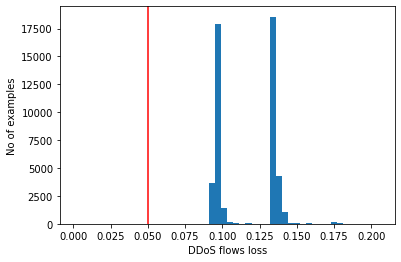

Anomalies detected: 99.95188787783704 %.


In [33]:
ddos = X_test[np.where(test_labels == 2)]
reconstructions = autoencoder.predict(ddos)
test_loss = tf.keras.losses.mae(reconstructions, ddos)

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("DDoS flows loss")
plt.ylabel("No of examples")
plt.axvline(x = th, color = 'r', label = 'axvline - full height')
plt.show()

print("Anomalies detected: " + str((len(np.where(test_loss.numpy() > th)[0]) / len(test_loss.numpy())) * 100), "%.")

18/18 [==============================] - 0s 2ms/step


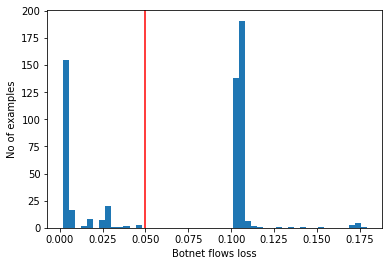

Anomalies detected: 61.94690265486725 %.


In [34]:
bot = X_test[np.where(test_labels == 3)]
reconstructions = autoencoder.predict(bot)
test_loss = tf.keras.losses.mae(reconstructions, bot)

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Botnet flows loss")
plt.ylabel("No of examples")
plt.axvline(x = th, color = 'r', label = 'axvline - full height')
plt.show()

print("Anomalies detected: " + str((len(np.where(test_loss.numpy() > th)[0]) / len(test_loss.numpy())) * 100), "%.")

128/128 [==============================] - 0s 1ms/step


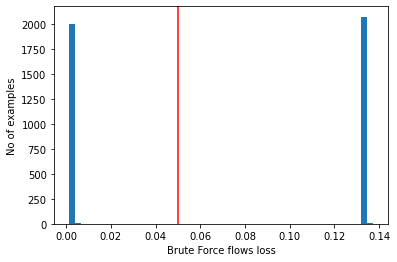

Anomalies detected: 50.87933561309234 %.


In [35]:
brute_force = X_test[np.where(test_labels == 4)]
reconstructions = autoencoder.predict(brute_force)
test_loss = tf.keras.losses.mae(reconstructions, brute_force)

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Brute Force flows loss")
plt.ylabel("No of examples")
plt.axvline(x = th, color = 'r', label = 'axvline - full height')
plt.show()

print("Anomalies detected: " + str((len(np.where(test_loss.numpy() > th)[0]) / len(test_loss.numpy())) * 100), "%.")

1/1 [==============================] - 0s 16ms/step


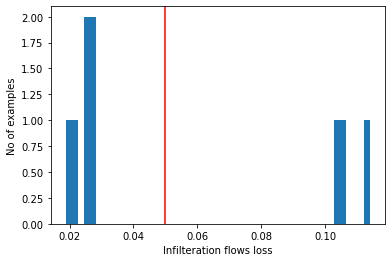

Anomalies detected: 33.33333333333333 %.


In [36]:
inf = X_test[np.where(test_labels == 5)]
reconstructions = autoencoder.predict(inf)
test_loss = tf.keras.losses.mae(reconstructions, inf)

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Infilteration flows loss")
plt.ylabel("No of examples")
plt.axvline(x = th, color = 'r', label = 'axvline - full height')
plt.show()

print("Anomalies detected: " + str((len(np.where(test_loss.numpy() > th)[0]) / len(test_loss.numpy())) * 100), "%.")

12/12 [==============================] - 0s 2ms/step


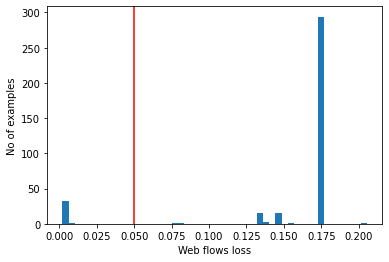

Anomalies detected: 90.93406593406593 %.


In [37]:
web = X_test[np.where(test_labels == 6)]
reconstructions = autoencoder.predict(web)
test_loss = tf.keras.losses.mae(reconstructions, web)

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Web flows loss")
plt.ylabel("No of examples")
plt.axvline(x = th, color = 'r', label = 'axvline - full height')
plt.show()

print("Anomalies detected: " + str((len(np.where(test_loss.numpy() > th)[0]) / len(test_loss.numpy())) * 100), "%.")

In [38]:
import itertools
def plot_confusion_matrix(cm, title, classes=['normal', 'abnormal'], save=False, save_as='MyFigure.png', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    
    fmt = '.1%'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment='center', color='white' if cm[i,j] > thresh else 'black')
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    if save:
        plt.savefig(save_as, dpi=100)

Deberemos elegir el valor de *threshold* que mejor creemos que separa las anomalías.

In [39]:
%%time
preds = autoencoder.pred(test_data, th)

CPU times: user 148 ms, sys: 188 ms, total: 336 ms
Wall time: 44.1 ms


In [40]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score

              precision    recall  f1-score   support

           0    0.91198   0.69897   0.79139    647015
           1    0.38718   0.73816   0.50794    166705

    accuracy                        0.70700    813720
   macro avg    0.64958   0.71857   0.64966    813720
weighted avg    0.80446   0.70700   0.73332    813720

AUC: 71.9%


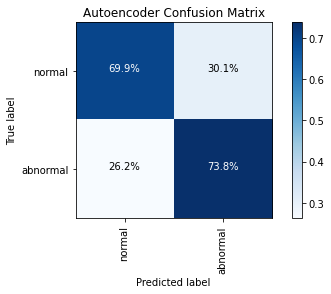

In [41]:
labels = np.where(y_test > 0, 1, y_test)
print(classification_report(labels, preds, digits=5))
print('AUC:','{:.1%}'.format(roc_auc_score(labels, preds)))
cm = confusion_matrix(labels, preds)
plot_confusion_matrix(cm, title='Autoencoder Confusion Matrix')

In [42]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

def kfold(X, y):
    scores = []
    skfold = StratifiedKFold(n_splits = 4)

    for train_index, test_index in skfold.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        normal_traffic = X_train[np.where(y_train == 0)]
        
        ae = AnomalyDetector()
        ae.compile(optimizer='adam', loss='mae')
        ae.fit(normal_traffic, normal_traffic)
        
        ac = accuracy_score(np.where(y_test > 0, 1, y_test).astype(bool), ae.pred(X_test, 0.05))
        print(ac)
        scores.append(ac)
    return scores

In [43]:
df = pd.read_csv('/home/jovyan/CIC-IDS-2017/CIC-IDS-2017-train.csv', sep=',', low_memory=False)
y_train = df.pop('Label')
X_train = np.delete(df.values, [1,2,7,8,9,10,11,13,15,18,20,21], 1)

results = kfold(X_train, y_train)
np.mean(results)

2344/2344 [==============================] - 5s 2ms/step - loss: 0.1090
0.6676742857142857
2344/2344 [==============================] - 5s 2ms/step - loss: 0.1033
0.6675371428571428
2344/2344 [==============================] - 5s 2ms/step - loss: 0.0964
0.6701257142857143
2344/2344 [==============================] - 5s 2ms/step - loss: 0.0941
0.6670914285714286


0.6681071428571429